# Comparative Analysis of Adaptive Filtering and Neural Network-Based Approaches for Audio Signal Denoising
## Signal, Image and Video - University of Trento

### M. Prosperi


This project investigates the denoising of audio signals through the application of adaptive filtering techniques, including Least Mean Squares (LMS) and Normalized Least Mean Squares (NLMS), alongside a neural network-based approach. The study is divided into two main phases to systematically evaluate the performance of these methods.

The first phase involves the use of synthetic audio signals, where each denoising method is assessed both qualitatively (through visual inspection of the results) and quantitatively using objective metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and the coefficient of determination (R²). This controlled environment allows for a rigorous comparison of the models’ effectiveness under well-defined conditions.

The second phase extends the analysis to real-world audio signals, utilizing the NOIZEUS Speech Corpus (available at https://ecs.utdallas.edu/loizou/speech/noizeus/), a dataset that provides speech signals with various noise conditions. By applying the denoising techniques to this dataset, the project evaluates the practical applicability and robustness of each method in real-world scenarios.



# Part 1: Synthetic signal denoising
1. Import all necessary libraries:
- **os** --> provides functions for interacting with the operating system, useful for file and directory manipulation
- **torch** --> powerful ML library used for building and training deep learning models
- **numpy** --> library for numerical computing in python
- **matplotlib.pyplot** --> plotting library used for creating visualizations
- **sklearn.metrics** --> Provides functions for evaluating machine learning models using metrics like mean squared error (MSE), mean absolute error (MAE), and R² scores, essential for quantifying denoising performance
- **sklearn.model_selection.train_test_split** --> useful to split dataset into training and testing
- **scipy.io.wavfile** --> used for reading and writing .wav files, crucial for loading the dataset and saving processed signals for further analysis or playback


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from scipy.io.wavfile import write

2. Set parameters
- *window_size* = size of the input window used to create the training data for the neural network. It specifies how many past samples are used to predict the next sample
- *learning_rate* = 	Learning rate used to optimize the neural network. Determines the step size for weight updates during training
- *mu* = Learning factor (step size) for updating weights in the LMS and NLMS filters. Controls how quickly the filter adapts to the input signal
- *filter_order* = The order of the filter, representing the number of coefficients used in the LMS or NLMS filter. Corresponds to the number of past samples considered to generate a filtered output

In [ ]:
# Parameters
window_size = 4
learning_rate = 0.01
epochs = 200      # Training epochs
mu = 0.01      # Step size for LMS and NLMS filters
filter_order = 4
np.random.seed(0)    # Sets the seed for NumPy random number generator to ensure reproducibility of results

Text(0.5, 1.0, 'Clean signal')

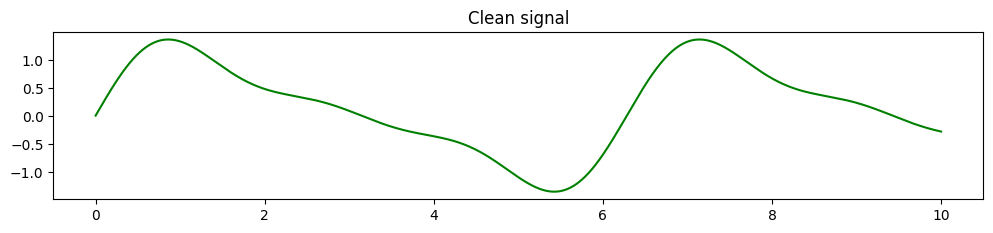

In [ ]:
# Generation of a sysnthetic noisy signal
t = np.linspace(0, 10, 2000)  # Signal with 2000 samples
clean_signal = np.sin(t) + 0.5 * np.sin(2*t) + 0.2 * np.sin(3*t)  # Clean signal
noise = np.random.normal(0, 0.5, t.shape)  # Noise
noisy_signal = clean_signal + noise      # Noisy signal obtained by adding noise to the clean one

# Let's display it using plt
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(t, clean_signal, label="Clean Signal", color="g")
plt.title("Clean signal")

3. LMS filter

The LMS (Least Mean Squares) filter is an adaptive filtering technique commonly used for noise cancellation in audio signals. Its goal is to minimize the error between a desired signal and the output of the filter, adjusting its weights dynamically to adapt to changes in the noise characteristics.
The following implemented function takes as parameters:
- **noisy_signal** --> input noisy signal
- **desired_signal** --> desired (clean) signal
- **mu** --> learning factor or step size
- **filter_order** --> order of the filter described before

and it returns:
-  **filtered_signal** --> the filtered version of the noisy signal
- **weights** --> final weights of the filter

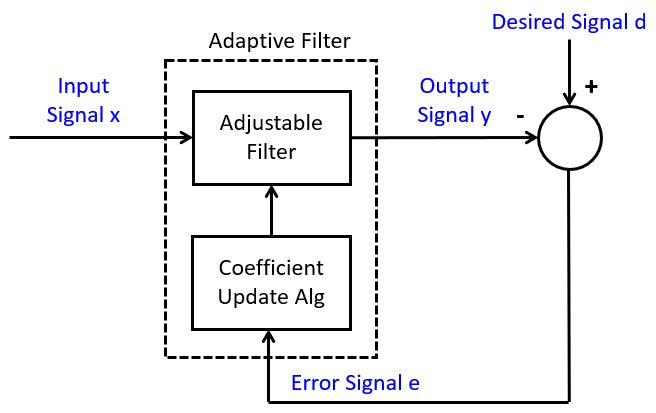

In [ ]:
# LMS Filter
def lms_filter(noisy_signal, desired_signal, mu, filter_order):
    # Number of samples in the noisy signal
    n_samples = len(noisy_signal)

    # Initialize filter weights to zeros
    weights = np.zeros(filter_order)

    # Initialize the filtered signal (output) array
    filtered_signal = np.zeros(n_samples)

    # Loop over the samples starting from the 'filter_order' index
    for i in range(filter_order, n_samples):
        # Extract the input window (a portion of the noisy signal)
        # Reversed because we're applying the filter from the most recent sample
        x = noisy_signal[i - filter_order:i][::-1]

        # Compute the output of the filter (dot product of weights and input window)
        y = np.dot(weights, x)

        # Calculate the error (difference between the desired signal and filter output)
        error = desired_signal[i] - y

        # Update the filter weights using the LMS rule
        weights += 2 * mu * error * x

        # Store the filtered signal output
        filtered_signal[i] = y

    # Return the filtered signal and the final filter weights
    return filtered_signal, weights

4. NLMS filter

The NLMS (Normalized Least Mean Squares) filter is a variation of the LMS filter that normalizes the update rule by the power of the input signal. This helps improve stability and convergence, especially when the input signal has high variance or fluctuates significantly.
Inputs and outputs are the same of LMS but an *epsilon* input variable is added in order to avoid divion by zero (default is 1e-6).

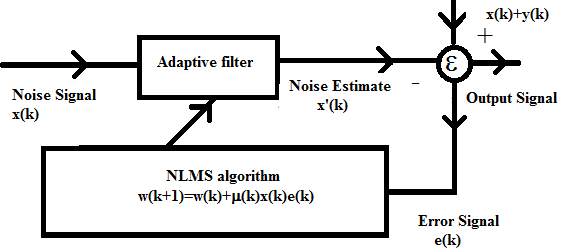

In [ ]:
# NLMS Filter
def nlms_filter(noisy_signal, desired_signal, mu, filter_order, epsilon=1e-6):
    # Number of samples in the noisy signal
    n_samples = len(noisy_signal)

    # Initialize filter weights to zeros
    weights = np.zeros(filter_order)

    # Initialize the filtered signal (output) array
    filtered_signal = np.zeros(n_samples)

    # Loop over the samples starting from the 'filter_order' index
    for i in range(filter_order, n_samples):
        # Extract the input window (a portion of the noisy signal)
        # Reversed because we're applying the filter from the most recent sample
        x = noisy_signal[i-filter_order:i][::-1]

        # Compute the output of the filter (dot product of weights and input window)
        y = np.dot(weights, x)

        # Calculate the error (difference between the desired signal and filter output)
        error = desired_signal[i] - y

        # Calculate the normalization factor (sum of squared inputs + epsilon)
        normalization_factor = np.dot(x, x) + epsilon

        # Update the filter weights using the NLMS update rule
        weights += (2 * mu * error * x) / normalization_factor  # NLMS weights update

        # Store the filtered signal output
        filtered_signal[i] = y

    # Return the filtered signal and the final filter weights
    return filtered_signal, weights

5. We need to prepare the dataset for the neural network


In [ ]:
# Function to prepare data for training
def prepare_data(noisy_signal, desired_signal, window_size):
    """
    Prepares the data for training an adaptive filter or machine learning model.

    Parameters:
        noisy_signal (array-like): The noisy input signal.
        desired_signal (array-like): The clean desired output signal.
        window_size (int): The size of the sliding window used for feature extraction.

    Returns:
        X (np.array): The feature matrix where each row is a window of the noisy signal.
        y (np.array): The target vector containing the corresponding desired signal values.
    """
    # Initialize feature matrix X and target vector y
    X, y = [], []

    # Loop over the signal starting from the index equal to 'window_size'
    for i in range(window_size, len(noisy_signal)):
        # Extract a window of the noisy signal and append it as a feature
        X.append(noisy_signal[i - window_size:i])
        # Append the corresponding value from the desired signal as the target
        y.append(desired_signal[i])

    # Convert the lists to NumPy arrays for efficient processing
    return np.array(X), np.array(y)

# Prepare the dataset
# X: Feature matrix with sliding windows of the noisy signal
# y: Target vector with corresponding values from the desired signal
X, y = prepare_data(noisy_signal, clean_signal, window_size)

# Split the data into training (70%) and temporary (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the temporary set into validation (50%) and test (50%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the sizes of the datasets for verification
print(f"Train size: {X_train.shape}, Validation size: {X_val.shape}, Test size: {X_test.shape}")

Train size: (1397, 4), Validation size: (299, 4), Test size: (300, 4)


6. Tensors are a core data structure in many deep learning frameworks like PyTorch and TensorFlow. They are similar to NumPy arrays but are designed to enable operations that are optimized for hardware acceleration, such as GPUs.

In [ ]:
# Tensor conversions
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    """
    A simple feedforward neural network for regression tasks.

    Architecture:
    - Input layer: Accepts data of size `input_size`.
    - Hidden layer: Fully connected layer with 10 units and ReLU activation.
    - Output layer: Fully connected layer with 1 unit (for regression output).
    """
    def __init__(self, input_size):
        """
        Initialize the model architecture.

        Parameters:
            input_size (int): Number of input features (equal to `window_size`).
        """
        super(SimpleNN, self).__init__()

        # First fully connected layer: maps input_size -> 10
        self.fc1 = nn.Linear(input_size, 10)

        # Second fully connected layer: maps 10 -> 1
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        """
        Forward pass of the neural network.

        Parameters:
            x (torch.Tensor): Input tensor with shape [batch_size, input_size].

        Returns:
            torch.Tensor: Output tensor with shape [batch_size, 1].
        """
        # Apply the first layer followed by ReLU activation
        x = torch.relu(self.fc1(x))

        # Apply the second layer to produce the output
        x = self.fc2(x)
        return x

# Initialize the model with the input size equal to the window size
model = SimpleNN(window_size)

# Define the loss function for regression (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer for model parameter updates
# Adam optimizer is chosen for its adaptive learning rate capabilities
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

7. We defined our NN model, now let's run the training phase.

In [ ]:
# Training loop for the neural network
for epoch in range(epochs):  # Loop over the specified number of epochs
    model.train()  # Set the model to training mode (enables dropout, batchnorm, etc., if present)
    optimizer.zero_grad()  # Clear gradients from the previous iteration

    # Forward pass: compute predictions on the training set
    outputs = model(X_train_tensor).squeeze()  # Squeeze to remove extra dimensions if needed
    loss = criterion(outputs, y_train_tensor)  # Compute training loss using MSELoss

    # Backward pass: compute gradients and update weights
    loss.backward()  # Compute gradients of the loss w.r.t. model parameters
    optimizer.step()  # Update model parameters using the optimizer

    # Validation phase
    model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
    with torch.no_grad():  # Disable gradient computation for efficiency
        val_outputs = model(X_val_tensor).squeeze()  # Predictions on validation set
        val_loss = criterion(val_outputs, y_val_tensor)  # Compute validation loss

    # Log training and validation loss every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Testing the neural network on the entire dataset
X_tensor = torch.tensor(X, dtype=torch.float32)  # Convert feature matrix to tensor
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation for testing
    nn_output = model(X_tensor).squeeze().numpy()  # Predictions on the entire dataset
    nn_loss = mean_squared_error(y, nn_output)  # Compute test loss using Mean Squared Error
    print(f"Test Loss (Neural Network): {nn_loss:.4f}")  # Print the final test loss

Epoch [20/200], Train Loss: 0.0941, Val Loss: 0.0879
Epoch [40/200], Train Loss: 0.0655, Val Loss: 0.0580
Epoch [60/200], Train Loss: 0.0585, Val Loss: 0.0573
Epoch [80/200], Train Loss: 0.0555, Val Loss: 0.0519
Epoch [100/200], Train Loss: 0.0542, Val Loss: 0.0501
Epoch [120/200], Train Loss: 0.0535, Val Loss: 0.0489
Epoch [140/200], Train Loss: 0.0531, Val Loss: 0.0481
Epoch [160/200], Train Loss: 0.0528, Val Loss: 0.0476
Epoch [180/200], Train Loss: 0.0526, Val Loss: 0.0472
Epoch [200/200], Train Loss: 0.0525, Val Loss: 0.0470
Test Loss (Neural Network): 0.0523


8. Apply LMS and NLMS filters

In [ ]:
filtered_signal_lms, _ = lms_filter(noisy_signal, clean_signal, mu, filter_order)
lms_loss = mean_squared_error(clean_signal[filter_order:], filtered_signal_lms[filter_order:])
print(f"Test Loss (LMS Filter): {lms_loss:.4f}")

filtered_signal_nlms, _ = nlms_filter(noisy_signal, clean_signal, mu, filter_order)
nlms_loss = mean_squared_error(clean_signal[filter_order:], filtered_signal_nlms[filter_order:])
print(f"Test Loss (NLMS Filter): {nlms_loss:.4f}")

Test Loss (LMS Filter): 0.0468
Test Loss (NLMS Filter): 0.0572


9. Calculate metrics to evaluate these three methods

In [ ]:
# Metrics calculation for the Neural Network
mse_nn = mean_squared_error(y, nn_output)  # Mean Squared Error for Neural Network
rmse_nn = np.sqrt(mse_nn)  # Root Mean Squared Error for Neural Network
r2_nn = r2_score(y, nn_output)  # Recompute R² score for Neural Network

print("\nNeural Network Performance:")  # Print metrics for Neural Network
print(f"  MSE: {mse_nn:.4f}")  # Print MSE
print(f"  RMSE: {rmse_nn:.4f}")  # Print RMSE
print(f"  R² Score: {r2_nn:.4f}")  # Print R²

# Metrics calculation for the LMS Filter
mse_lms = mean_squared_error(clean_signal[filter_order:], filtered_signal_lms[filter_order:])  # MSE for LMS filter
rmse_lms = np.sqrt(mse_lms)  # RMSE for LMS filter
r2_lms = r2_score(clean_signal[filter_order:], filtered_signal_lms[filter_order:])  # R² for LMS filter

print("\nLMS Filter Performance:")  # Print metrics for LMS filter
print(f"  MSE: {mse_lms:.4f}")  # Print MSE
print(f"  RMSE: {rmse_lms:.4f}")  # Print RMSE
print(f"  R² Score: {r2_lms:.4f}")  # Print R²

# Metrics calculation for the NLMS Filter
mse_nlms = mean_squared_error(clean_signal[filter_order:], filtered_signal_nlms[filter_order:])  # MSE for NLMS filter
rmse_nlms = np.sqrt(mse_nlms)  # RMSE for NLMS filter
r2_nlms = r2_score(clean_signal[filter_order:], filtered_signal_nlms[filter_order:])  # R² for NLMS filter

print("\nNLMS Filter Performance:")  # Print metrics for NLMS filter
print(f"  MSE: {mse_nlms:.4f}")  # Print MSE
print(f"  RMSE: {rmse_nlms:.4f}")  # Print RMSE
print(f"  R² Score: {r2_nlms:.4f}")  # Print R²


Neural Network Performance:
  MSE: 0.0523
  RMSE: 0.2287
  R² Score: 0.9080

LMS Filter Performance:
  MSE: 0.0468
  RMSE: 0.2164
  R² Score: 0.9177

NLMS Filter Performance:
  MSE: 0.0572
  RMSE: 0.2391
  R² Score: 0.8995


10. Let's plot results for each technique

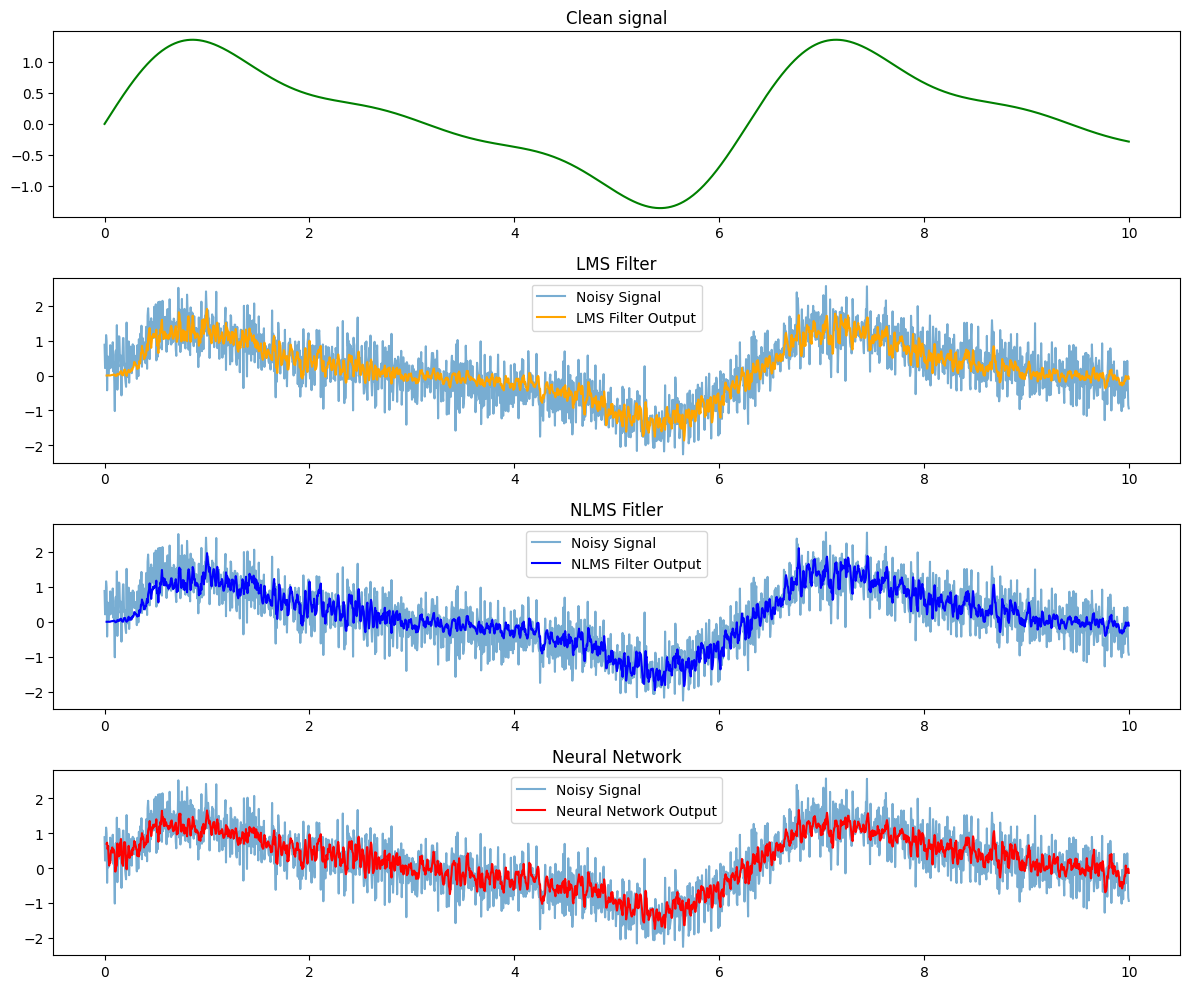

In [ ]:
# Plotting results
plt.figure(figsize=(12, 10))

# First plot the original clean signal
plt.subplot(4, 1, 1)
plt.plot(t, clean_signal, label="Clean Signal", color="g")
plt.title("Clean signal")

# LMS filter
plt.subplot(4, 1, 2)
plt.plot(t, noisy_signal, label="Noisy Signal", alpha=0.6)
plt.plot(t[filter_order:], filtered_signal_lms[filter_order:], label="LMS Filter Output", color="orange")
plt.title("LMS Filter")
plt.legend()

# NLMS filter
plt.subplot(4, 1, 3)
plt.plot(t, noisy_signal, label="Noisy Signal", alpha=0.6)
plt.plot(t[filter_order:], filtered_signal_nlms[filter_order:], label="NLMS Filter Output", color="blue")
plt.title("NLMS Fitler")
plt.legend()

# Neural Network
plt.subplot(4, 1, 4)
plt.plot(t, noisy_signal, label="Noisy Signal", alpha=0.6)
plt.plot(t[window_size:], nn_output, label="Neural Network Output", color="red")
plt.title("Neural Network")
plt.legend()

plt.tight_layout()
plt.show()

The results obtained are not particularly convincing; however, we have gained a solid understanding of the functioning and behavior of these filters. This knowledge enables us to proceed with their application to real-world audio signals, specifically those corrupted by "train" noise.

# Part 2 - Applying denoising techniques on real-world audio signals
The dataset used for this study comprises 30 audio signals of human speech, generated by three male and three female speakers. These signals have been artificially corrupted by adding train noise to each recording. The audio files are saved in the WAV format, utilizing 16-bit PCM encoding in mono. The original signal-to-noise ratio (SNR) of the corrupted signals is set to 10 dB.

1. The first step is to add one more hyperparameter, *batch_size* that determines the number of samples processed at once before the model updates its parameters. During training, the dataset is typically divided into smaller subsets called batches, and the model processes these batches iteratively.

In [ ]:
# Hyperparameters
epochs = 15
batch_size = 64

2. In order to load  and prepare our dataset from the directory we need to define the following functions

In [ ]:
# Function to load signals from a specified directory
def load_signals_from_directory(directory):
    """
    Loads all .wav files from the specified directory, normalizes the signals,
    and stores them in a list.

    Args:
        directory (str): Path to the directory containing .wav files.

    Returns:
        signals (list): List of normalized audio signals.
        fs (int): Sampling rate of the audio files (assumes all files have the same sampling rate).
    """
    signals = []
    for filename in sorted(os.listdir(directory)):  # Ensures files are loaded in a consistent order
        if filename.endswith(".wav"):  # Processes only .wav files
            fs, signal = wavfile.read(os.path.join(directory, filename))  # Load the .wav file
            signal = signal / np.max(np.abs(signal))  # Normalize the signal to the range [-1, 1]
            signals.append(signal)  # Append the normalized signal to the list
    return signals, fs


# Function to prepare the dataset for training
def prepare_dataset(noisy_signals, clean_signals, window_size):
    """
    Prepares the dataset for supervised learning by extracting overlapping windows
    from the noisy signals and their corresponding clean signals.

    Args:
        noisy_signals (list): List of noisy audio signals.
        clean_signals (list): List of clean audio signals (ground truth).
        window_size (int): Size of the input window for feature extraction.

    Returns:
        X (ndarray): Array of input features (overlapping windows from noisy signals).
        y (ndarray): Array of target values (corresponding clean signal values).
    """
    X, y = [], []
    for noisy, clean in zip(noisy_signals, clean_signals):  # Iterate through paired noisy and clean signals
        for i in range(window_size, len(noisy)):  # Sliding window over the noisy signal
            X.append(noisy[i-window_size:i])  # Extract the current window as an input feature
            y.append(clean[i])  # Use the corresponding clean signal value as the target
    return np.array(X), np.array(y)

3. In order to assess the goodness of these methods we will add two more useful metrics: Peak-signal-to-noise-ratio (PSNR) and Signal-to-noise-ratio (SNR).

In [ ]:
# Function to calculate the Peak Signal-to-Noise Ratio (PSNR)
def calculate_psnr(signal, reference_signal):
    """
    Computes the PSNR (Peak Signal-to-Noise Ratio) between the processed signal
    and the reference (clean) signal. PSNR is a common metric to evaluate the
    quality of a signal after denoising or compression.

    Args:
        signal (ndarray): The processed signal (e.g., denoised output).
        reference_signal (ndarray): The original clean signal (ground truth).

    Returns:
        float: PSNR value in decibels (dB). Returns infinity if the two signals are identical.
    """
    mse = np.mean((signal - reference_signal) ** 2)  # Mean Squared Error
    if mse == 0:  # No difference between signals
        return float('inf')  # Infinite PSNR
    max_val = np.max(reference_signal)  # Maximum amplitude of the reference signal
    psnr = 20 * np.log10(max_val / np.sqrt(mse))  # PSNR formula
    return psnr


# Function to calculate the Signal-to-Noise Ratio (SNR)
def calculate_snr(signal, reference_signal):
    """
    Computes the SNR (Signal-to-Noise Ratio) between the processed signal
    and the reference (clean) signal. SNR indicates the relative strength of the
    desired signal compared to the noise.

    Args:
        signal (ndarray): The processed signal (e.g., denoised output).
        reference_signal (ndarray): The original clean signal (ground truth).

    Returns:
        float: SNR value in decibels (dB). Returns infinity if there is no noise in the signal.
    """
    signal_power = np.mean(reference_signal ** 2)  # Power of the clean signal
    noise_power = np.mean((signal - reference_signal) ** 2)  # Power of the noise
    if noise_power == 0:  # No noise present
        return float('inf')  # Infinite SNR
    snr = 10 * np.log10(signal_power / noise_power)  # SNR formula
    return snr

4. Preparing the dataset

In [ ]:
# Load signals
clean_signals, fs_clean = load_signals_from_directory('/content/drive/MyDrive/siv_project/audios/clean') # Modify with path to clean audios
noisy_signals, fs_noisy = load_signals_from_directory('/content/drive/MyDrive/siv_project/audios/noise_train') # Modify with path to noisy audios

# Check if both signals have the same frequencies
assert fs_clean == fs_noisy, "Sampling frequencies do not match!"

# Prepare dataset
X, y = prepare_dataset(noisy_signals, clean_signals, window_size)

# Split dataset into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

print(f"Full dataset size (X, y): {X.shape}, {y.shape}")
print(f"Training set size (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Validation set size (X_val, y_val): {X_val.shape}, {y_val.shape}")
print(f"Testing set size (X_test, y_test): {X_test.shape}, {y_test.shape}")

Full dataset size (X, y): (640201, 4), (640201,)
Training set size (X_train, y_train): torch.Size([384120, 4]), torch.Size([384120])
Validation set size (X_val, y_val): torch.Size([128040, 4]), torch.Size([128040])
Testing set size (X_test, y_test): torch.Size([128041, 4]), torch.Size([128041])


5. Define the neural network structure

In [ ]:
# Define the neural network model
class AdvancedNN(nn.Module):
    # Constructor to initialize the layers
    def __init__(self, input_size):
        super(AdvancedNN, self).__init__()  # Initialize the parent class nn.Module
        self.fc1 = nn.Linear(input_size, 64)  # First fully connected layer (input -> 64 units)
        self.fc2 = nn.Linear(64, 32)  # Second fully connected layer (64 units -> 32 units)
        self.fc3 = nn.Linear(32, 1)  # Third fully connected layer (32 units -> 1 output)

    # Forward pass through the network
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation after the second layer
        x = self.fc3(x)  # No activation after the last layer (for regression tasks)
        return x

# Initialize the model with the input size (window size)
model = AdvancedNN(window_size)  # Create an instance of the AdvancedNN model
criterion = nn.MSELoss()  # Use Mean Squared Error (MSE) as the loss function (common for regression)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Use Adam optimizer for training with a learning rate

# NN training phase
num_batches = len(X_train) // batch_size  # Calculate number of batches for the training set

# Loop over the number of epochs
for epoch in range(epochs):
    epoch_loss = 0  # Initialize the loss for the current epoch
    for i in range(num_batches):  # Loop over each batch
        start = i * batch_size  # Start index of the current batch
        end = start + batch_size  # End index of the current batch
        batch_X = X_train[start:end]  # Select the input data for the current batch
        batch_y = y_train[start:end]  # Select the target data for the current batch

        optimizer.zero_grad()  # Clear the gradients from the previous iteration
        outputs = model(batch_X).squeeze()  # Get model predictions for the batch and remove unnecessary dimensions
        loss = criterion(outputs, batch_y)  # Calculate the loss between predicted and true values
        loss.backward()  # Backpropagate the gradients to update the weights
        optimizer.step()  # Update the model parameters using the optimizer

        epoch_loss += loss.item()  # Accumulate the loss for the current epoch

    # Validation loss (evaluating the model on the validation set after each epoch)
    with torch.no_grad():  # Disable gradient computation (faster inference)
        val_outputs = model(X_val).squeeze()  # Get model predictions for the validation set
        val_loss = criterion(val_outputs, y_val)  # Calculate validation loss

    # Print the loss for the current epoch and validation loss
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Save the trained model to a file
torch.save(model.state_dict(), 'advanced_nn_model.pth')  # Save the model's parameters to a .pth file

Epoch [1/15], Loss: 0.0050, Validation Loss: 0.0048
Epoch [2/15], Loss: 0.0048, Validation Loss: 0.0046
Epoch [3/15], Loss: 0.0048, Validation Loss: 0.0046
Epoch [4/15], Loss: 0.0047, Validation Loss: 0.0046
Epoch [5/15], Loss: 0.0047, Validation Loss: 0.0046
Epoch [6/15], Loss: 0.0047, Validation Loss: 0.0046
Epoch [7/15], Loss: 0.0047, Validation Loss: 0.0046
Epoch [8/15], Loss: 0.0047, Validation Loss: 0.0046
Epoch [9/15], Loss: 0.0047, Validation Loss: 0.0046
Epoch [10/15], Loss: 0.0047, Validation Loss: 0.0046
Epoch [11/15], Loss: 0.0047, Validation Loss: 0.0046
Epoch [12/15], Loss: 0.0047, Validation Loss: 0.0046
Epoch [13/15], Loss: 0.0047, Validation Loss: 0.0046
Epoch [14/15], Loss: 0.0047, Validation Loss: 0.0046
Epoch [15/15], Loss: 0.0047, Validation Loss: 0.0047


6. Now we can evaluate and visually choose the best apporoach

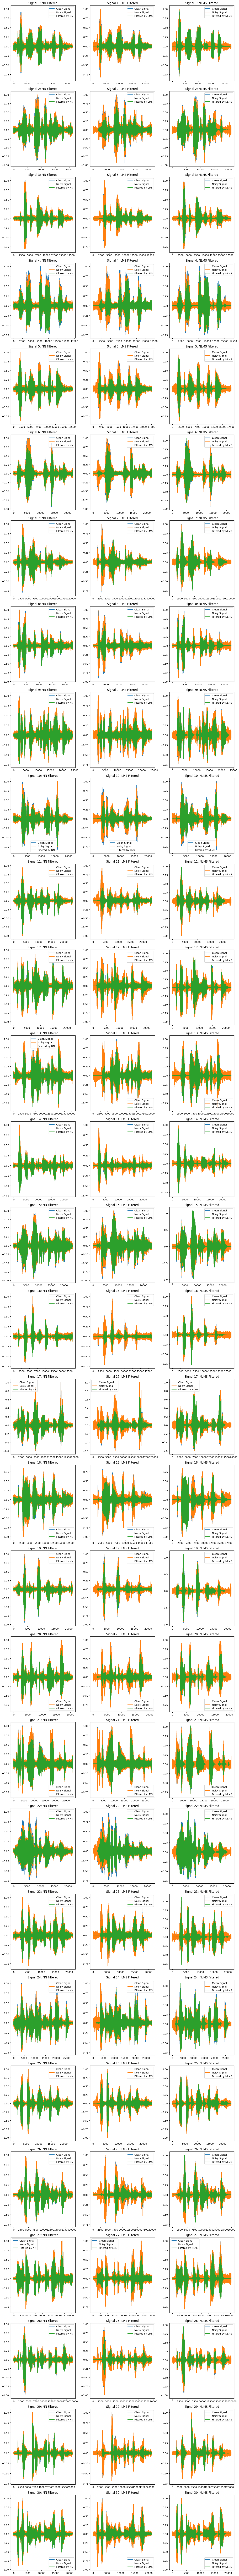


NN Metrics:
MSE: 0.0046 ± 0.0019
MAE: 0.0382 ± 0.0088
PSNR: 23.5791 ± 1.9387
SNR: 4.4268 ± 1.0311
R2: 0.6294 ± 0.0818

LMS Metrics:
MSE: 0.0060 ± 0.0019
MAE: 0.0432 ± 0.0089
PSNR: 22.3389 ± 1.5516
SNR: 3.1867 ± 0.9252
R2: 0.5091 ± 0.1022

NLMS Metrics:
MSE: 0.0042 ± 0.0017
MAE: 0.0332 ± 0.0076
PSNR: 24.0235 ± 1.9170
SNR: 4.8713 ± 1.0160
R2: 0.6654 ± 0.0766


In [ ]:
# Dictionaries to store evaluation metrics for each filtering method
metrics_nn = {'MSE': [], 'MAE': [], 'PSNR': [], 'SNR': [], 'R2': []}
metrics_lms = {'MSE': [], 'MAE': [], 'PSNR': [], 'SNR': [], 'R2': []}
metrics_nlms = {'MSE': [], 'MAE': [], 'PSNR': [], 'SNR': [], 'R2': []}

# Set up the figure for plotting results for each clean signal
plt.figure(figsize=(14, 5 * len(clean_signals)))

# Iterate over each pair of clean and noisy signals
for idx, (clean_signal, noisy_signal) in enumerate(zip(clean_signals, noisy_signals)):

    # NN Filtering
    with torch.no_grad():  # Disable gradient computation for inference
        X_signal, _ = prepare_dataset([noisy_signal], [clean_signal], window_size)  # Prepare data for NN
        filtered_nn = model(torch.tensor(X_signal, dtype=torch.float32)).squeeze().numpy()  # Run NN model on the noisy signal

    # LMS Filtering
    filtered_lms, _ = lms_filter(noisy_signal, clean_signal, mu, window_size)  # Apply LMS filtering

    # NLMS Filtering
    filtered_nlms, _ = nlms_filter(noisy_signal, clean_signal, mu, window_size)  # Apply NLMS filtering

    # Metrics for NN
    mse_nn = mean_squared_error(clean_signal[window_size:], filtered_nn)  # MSE for NN
    mae_nn = mean_absolute_error(clean_signal[window_size:], filtered_nn)  # MAE for NN
    psnr_nn = calculate_psnr(filtered_nn, clean_signal[window_size:])  # PSNR for NN
    snr_nn = calculate_snr(filtered_nn, clean_signal[window_size:])  # SNR for NN
    r2_nn = r2_score(clean_signal[window_size:], filtered_nn)  # R2 for NN

    # Store NN metrics
    metrics_nn['MSE'].append(mse_nn)
    metrics_nn['MAE'].append(mae_nn)
    metrics_nn['PSNR'].append(psnr_nn)
    metrics_nn['SNR'].append(snr_nn)
    metrics_nn['R2'].append(r2_nn)

    # Metrics for LMS
    filtered_lms = filtered_lms[window_size:]  # Trim the filtered LMS signal
    clean_signal_trimmed = clean_signal[window_size:]  # Trim the clean signal for comparison

    mse_lms = mean_squared_error(clean_signal_trimmed, filtered_lms)  # MSE for LMS
    mae_lms = mean_absolute_error(clean_signal_trimmed, filtered_lms)  # MAE for LMS
    psnr_lms = calculate_psnr(filtered_lms, clean_signal_trimmed)  # PSNR for LMS
    snr_lms = calculate_snr(filtered_lms, clean_signal_trimmed)  # SNR for LMS
    r2_lms = r2_score(clean_signal_trimmed, filtered_lms)  # R2 for LMS

    # Store LMS metrics
    metrics_lms['MSE'].append(mse_lms)
    metrics_lms['MAE'].append(mae_lms)
    metrics_lms['PSNR'].append(psnr_lms)
    metrics_lms['SNR'].append(snr_lms)
    metrics_lms['R2'].append(r2_lms)

    # Metrics for NLMS
    filtered_nlms = filtered_nlms[window_size:]  # Trim the filtered NLMS signal
    clean_signal_trimmed = clean_signal[window_size:]  # Trim the clean signal for comparison

    mse_nlms = mean_squared_error(clean_signal_trimmed, filtered_nlms)  # MSE for NLMS
    mae_nlms = mean_absolute_error(clean_signal_trimmed, filtered_nlms)  # MAE for NLMS
    psnr_nlms = calculate_psnr(filtered_nlms, clean_signal_trimmed)  # PSNR for NLMS
    snr_nlms = calculate_snr(filtered_nlms, clean_signal_trimmed)  # SNR for NLMS
    r2_nlms = r2_score(clean_signal_trimmed, filtered_nlms)  # R2 for NLMS

    # Store NLMS metrics
    metrics_nlms['MSE'].append(mse_nlms)
    metrics_nlms['MAE'].append(mae_nlms)
    metrics_nlms['PSNR'].append(psnr_nlms)
    metrics_nlms['SNR'].append(snr_nlms)
    metrics_nlms['R2'].append(r2_nlms)

    # Plot the clean, noisy, and filtered signals for each method
    plt.subplot(len(clean_signals), 3, 3 * idx + 1)
    plt.plot(clean_signal, label='Clean Signal')
    plt.plot(noisy_signal, label='Noisy Signal')
    plt.plot(filtered_nn, label='Filtered by NN')
    plt.legend()
    plt.title(f"Signal {idx + 1}: NN Filtered")

    plt.subplot(len(clean_signals), 3, 3 * idx + 2)
    plt.plot(clean_signal, label='Clean Signal')
    plt.plot(noisy_signal, label='Noisy Signal')
    plt.plot(filtered_lms, label='Filtered by LMS')
    plt.legend()
    plt.title(f"Signal {idx + 1}: LMS Filtered")

    plt.subplot(len(clean_signals), 3, 3 * idx + 3)
    plt.plot(clean_signal, label='Clean Signal')
    plt.plot(noisy_signal, label='Noisy Signal')
    plt.plot(filtered_nlms, label='Filtered by NLMS')
    plt.legend()
    plt.title(f"Signal {idx + 1}: NLMS Filtered")

# Adjust the layout for the plots and display them
plt.tight_layout()
plt.show()

# Calculate and print average metrics with standard deviation for each method
avg_metrics_nn = {metric: (np.mean(values), np.std(values)) for metric, values in metrics_nn.items()}
avg_metrics_lms = {metric: (np.mean(values), np.std(values)) for metric, values in metrics_lms.items()}
avg_metrics_nlms = {metric: (np.mean(values), np.std(values)) for metric, values in metrics_nlms.items()}

# Print the results
print("\nNN Metrics:")
for metric, (mean_val, std_val) in avg_metrics_nn.items():
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

print("\nLMS Metrics:")
for metric, (mean_val, std_val) in avg_metrics_lms.items():
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

print("\nNLMS Metrics:")
for metric, (mean_val, std_val) in avg_metrics_nlms.items():
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

7. This cell first creates a directory for each of the 3 methods where we save all filtered signals in order to playback them if we want.

In [ ]:
# Directory to save filtered signals
output_dirs = {
    'NN': 'output/filtered_nn',
    'LMS': 'output/filtered_lms',
    'NLMS': 'output/filtered_nlms'
}

# Create directories if they do not exist
for dir_name in output_dirs.values():
    os.makedirs(dir_name, exist_ok=True)

# Process 30 signals
for idx in range(30):
    if idx >= len(clean_signals):  # Safety check in case there are fewer than 30 signals
        break

    clean_signal, noisy_signal = clean_signals[idx], noisy_signals[idx]

    # NN filtering
    with torch.no_grad():
        X_signal, _ = prepare_dataset([noisy_signal], [clean_signal], window_size)
        filtered_nn = model(torch.tensor(X_signal, dtype=torch.float32)).squeeze().detach().numpy()

    # LMS filtering
    filtered_lms, _ = lms_filter(noisy_signal, clean_signal, mu, window_size)

    # NLMS filtering
    filtered_nlms, _ = nlms_filter(noisy_signal, clean_signal, mu, window_size)

    # Save files
    file_name_nn = os.path.join(output_dirs['NN'], f"filtered_nn_{idx+1}.wav")
    file_name_lms = os.path.join(output_dirs['LMS'], f"filtered_lms_{idx+1}.wav")
    file_name_nlms = os.path.join(output_dirs['NLMS'], f"filtered_nlms_{idx+1}.wav")

    wavfile.write(file_name_nn, fs_clean, (filtered_nn * 32767).astype(np.int16))
    wavfile.write(file_name_lms, fs_clean, (filtered_lms * 32767).astype(np.int16))
    wavfile.write(file_name_nlms, fs_clean, (filtered_nlms * 32767).astype(np.int16))

    print(f"Saved filtered signals for audio {idx+1}")

Saved filtered signals for audio 1
Saved filtered signals for audio 2
Saved filtered signals for audio 3
Saved filtered signals for audio 4
Saved filtered signals for audio 5
Saved filtered signals for audio 6
Saved filtered signals for audio 7
Saved filtered signals for audio 8
Saved filtered signals for audio 9
Saved filtered signals for audio 10
